# PCA Using SVD

## 1. Preprocesamiento de Datos

Cargamos la base de datos de AT&T Database of Faces

In [1]:
import os
from PIL import Image
import numpy as np

# La ruta a tu directorio que contiene la base de datos de caras
directory_path = r'C:\Users\Pablo\OneDrive\Documentos\LOYOLA\TFG\archive'

# Lista para almacenar las imágenes
images = []
labels = []

# Recorrer el directorio y cargar cada imagen
for folder_name in os.listdir(directory_path):
    folder_path = os.path.join(directory_path, folder_name)
    if os.path.isdir(folder_path):
        # Suponiendo que cada subcarpeta corresponde a una persona diferente
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            # Asegúrate de que es un archivo de imagen
            if os.path.isfile(image_path) and image_name.endswith('.pgm'):
                # Cargar la imagen en escala de grises
                image = Image.open(image_path).convert('L')
                # Convertir la imagen en un array de numpy
                image_array = np.array(image)
                # Añadir la imagen al conjunto de datos
                images.append(image_array)
                # Añadir etiqueta o clasificación
                labels.append(folder_name)

# Convertir listas en arrays de numpy para su uso en algoritmos de aprendizaje automático
images = np.array(images)
labels = np.array(labels)


Ahora podemos encontrar que tenemos un array `images` con todas las imágenes cargadas y un array `labels` con las etiquetas correspondientes.

Para comprobar que el código haya funcionado correctamente hemos hecho varias pruebas.

### 1.1. Veririficamos las Dimensiones de los Arrays

Comprobamos el tamaño de los arrays `images` y `labels` para asegurarte de que coinciden con el número esperado de imágenes y etiquetas.

In [2]:
import matplotlib.pyplot as plt

# Verificar las dimensiones de los arrays
print(f'Número total de imágenes: {len(images)}')
print(f'Número total de etiquetas: {len(labels)}')

# Asegurarse de que cada imagen tiene una etiqueta correspondiente
assert len(images) == len(labels)

Número total de imágenes: 400
Número total de etiquetas: 400


### 1.2. Visualizar las Imágenes

Utilizamos matplotlib para visualizar algunas de las imágenes cargadas.

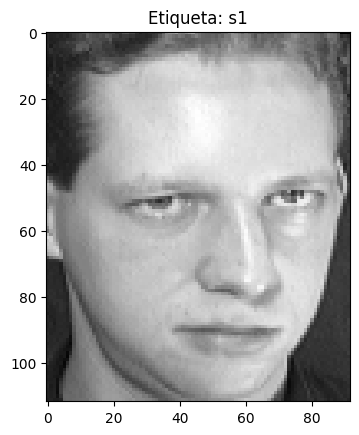

In [3]:
random_index = np.random.randint(0, len(images))
plt.imshow(images[random_index], cmap='gray')
plt.title(f'Etiqueta: {labels[random_index]}')
plt.show()

Para comprobar que las imágenes están en escala de grises vamos a ver que en las imágenes en escala de grises son aquellas en las que cada píxel representa una cantidad de luz, variando de negro en la menor intesidad a blanco en la mayor intesidad. Por otro lado, una imagen en color se representa con un array 3D, donde hay tres matrices de tamaño igual al de la imagen, cada una correspondiendo a uno de los canales de color: rojo, verde y azul. Esta es una manera simple de verificar si tus imágenes están en escala de grises:

In [4]:
# Comprobación de una imagen individual si es en escala de grises o no
def is_greyscale(img_array):
    if img_array.ndim == 2:
        return True  # La imagen es en escala de grises
    elif img_array.ndim == 3 and img_array.shape[2] == 1:
        return True  # La imagen es en escala de grises y tiene un solo canal
    elif img_array.ndim == 3 and img_array.shape[2] == 3:
        return False  # La imagen es en color
    else:
        raise ValueError("El formato de la imagen no es ni en escala de grises ni RGB estándar")

# Comprobar todas las imágenes
all_greyscale = all(is_greyscale(image) for image in images)


Imprimimos el resultado

In [5]:
if all_greyscale:
    print("Todas las imágenes están en escala de grises.")
else:
    print("Hay imágenes en color.")

Todas las imágenes están en escala de grises.


In [6]:
# Asumiendo que 'images' es una lista o array de arrays de numpy
unique_shapes = set(img.shape for img in images)

if len(unique_shapes) == 1:
    print(f"Todas las imágenes tienen elmismo tamaño: {unique_shapes.pop()}")
else:
    print("Las imágenes tienen tamaños diferentes:")
    for shape in unique_shapes:
        print(shape)


Todas las imágenes tienen elmismo tamaño: (112, 92)


## 2. Implementación de PCA usando SVD

### 2.1. Explicación teórica de como se puede aplicar SVD a PCA

Ya sabemos que PCA es una técnica estadística para simplificar la complejidad en sistemas multidimensionales, reduciendo el número de variables. Ahora que vamos a utilizar SVD debemos de presentarlo como un método matemático para descomponer matreices en productos de matrices más simples que le vienen particularmente bien a PCA. PCA busca las direcciones (componenetes principales) en los datos donde hay mayor varianza, es decir, donde los datos son mñas 'dispersos'. Utilizando las matemáticas podemos encontrar estos componenetes mediante la diagonalización de la matriz de covarianza. SVD descompone cualquier matriz en tres matrices ($U$, $\Sigma$, $V^{T}$), donde $\Sigma$ contiene los valores singulares que no dejan de ser la raíz cuadrada de los eigenvalues.Al aplicar SVD a nuestra matriz (base de datos), se obtienen los eigenvectors (en $V^{T}$ o $U$) y eigenvalues (en $\Sigma$) que PCA busca para determinar los componentes principales. En este caso vamos a utilizar esta técnica para aplicarla a un conjunto de datos de imágenes. A pesar de que no hay una regla estipulada sobre cuantas componentes debemos elegir, normalmente se suele hacer coger las primeras x componentes que nos expliquen el 80% de la explained variance. Ya sabemos como PCA nos ayda en la visualización de datos complejos, en la reducción de ruido y en la mejora de algoritmos de ML al reducir el número de vairables y al ayudarnos a conseguir quedarnos con las variables que nos explican la mayor varianza posible del conjunto de datos que tenemos.

### 2.2. Aplicación del algoritmo

In [7]:
# Suponiendo que 'images' es tu lista de arrays de imágenes
# Aplanar cada imagen para convertirla en un vector y almacenarla en una nueva lista
flattened_images = [image.flatten() for image in images]

# Convertir la lista de imágenes aplanadas en un array 2D de NumPy
# Cada fila del array representa una imagen
image_matrix = np.array(flattened_images)

# Centrar los datos restando la media
mean_vector = np.mean(image_matrix, axis=0)
centered_matrix = image_matrix - mean_vector

# Ahora 'centered_matrix' está lista para ser utilizada con PCA

In [8]:
def pca_svd(X):
    X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    U, S, Vt = np.linalg.svd(X_std, full_matrices=False)
    return U, S, Vt

In [9]:
U, S, Vt = pca_svd(centered_matrix)

In [10]:
# La matriz Vt se obtiene de la descomposición SVD
# El número total de componentes es igual al número de filas en Vt

num_total_componentes = S.shape[0]
print(f"El número total de componentes principales es: {num_total_componentes}")

El número total de componentes principales es: 400


## 3. Visualización de los Componentes Principales

In [11]:
# Suponiendo que S es tu matriz de valores singulares de la salida de pca_svd

# Calcular la varianza explicada por cada valor singular
varianza_por_componente = (S ** 2) / np.sum(S ** 2)

# Calcular la varianza explicada acumulativa
varianza_acumulada = np.cumsum(varianza_por_componente)

# Encontrar el número de componentes para explicar al menos el 80% de la varianza
num_componentes = np.argmax(varianza_acumulada >= 0.80) + 1  # +1 porque los índices en Python empiezan en 0

print(f'El número de componentes es en el que encontramos al menos un 80% de la varianza explicada es: {num_componentes}')

# num_componentes es el número de componentes principales que representan al menos el 80% de la varianza explicada

El número de componentes es en el que encontramos al menos un 80% de la varianza explicada es: 46


In [12]:
# Suponiendo que U, S, Vt son las salidas de tu función pca_svd
# y que 'image_matrix' es tu matriz original de imágenes

# Seleccionar los primeros k componentes de Vt
Vt_k = Vt[:num_componentes, :]

# Transformar los datos al espacio de componentes principales
# Usando la matriz original de imágenes centrada
X_centered = image_matrix - np.mean(image_matrix, axis=0)
X_pca = np.dot(X_centered, Vt_k.T)

# X_pca es ahora tu conjunto de datos transformado con k dimensiones

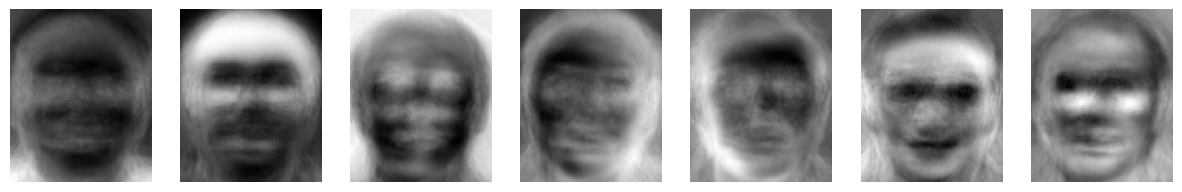

In [13]:
# Suponiendo que Vt es la matriz de tus componentes principales
image_shape = (112, 92)  # Forma de las imágenes originales
num_componentes = 7

# Visualizar los primeros num_components eigenfaces
fig, axes = plt.subplots(1, num_componentes, figsize=(15, 3))
for i in range(num_componentes):
    # Remodelar el eigenvector para que tenga la forma de una imagen
    eigenface = Vt[i].reshape(image_shape)
    
    # Mostrar la imagen
    ax = axes[i]
    ax.imshow(eigenface, cmap='gray')
    ax.axis('off')

plt.show()



En estas imñagenes podemos ver las 7 Componentes Principales en diferentes fotos. Podemos contemplar que en la primera se centra en el perfil de la camiseta, en la segunda se centra en el pelo y en la tercera se está centrando en el fondo de la imagen.

## 4. Reducción de Dimensionalidad y Reconstrucción de Imágenes

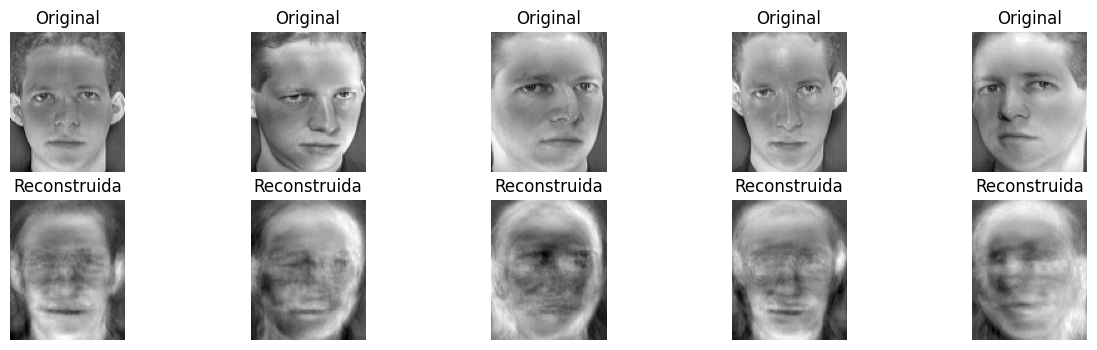

In [14]:
# Datos de las imágenes centrados (centered_matrix)
# Componentes principales (Vt)
# Número de componentes a utilizar para la reconstrucción
num_componentes = 46  # Define 'x' como el número de componentes que deseas usar

# Proyectar las imágenes en los componentes principales
proyecciones = np.dot(centered_matrix, Vt[:num_componentes].T)

# Reconstruir las imágenes desde el espacio de componentes principales
reconstrucciones = np.dot(proyecciones, Vt[:num_componentes]) + np.mean(centered_matrix, axis=0)

# Visualización de las imágenes originales y las reconstruidas
num_images = 5  # Número de imágenes a visualizar
fig, axes = plt.subplots(2, num_images, figsize=(15, 4))

for i in range(num_images):
    # Imagen original
    ax = axes[0, i]
    ax.imshow(centered_matrix[i].reshape(image_shape), cmap='gray')
    ax.axis('off')
    ax.set_title('Original')

    # Imagen reconstruida
    ax = axes[1, i]
    ax.imshow(reconstrucciones[i].reshape(image_shape), cmap='gray')
    ax.axis('off')
    ax.set_title('Reconstruida')

plt.show()


Antes hemos visto que las primeras 46 Componentes Principales representan el 80% de la varianza explicada. Así que aquí cogemos 5 imágenes y representamos esas imágenes con estas 46 Componentes y vemos la comparativa entre ambas imágenes.

## 5. Clasificación y Evaluación del Rendimiento

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import time
from sklearn.decomposition import PCA

# Suponiendo que 'images' es tu array de imágenes y 'labels' tus etiquetas
# Aplana cada imagen
n_samples = len(images)
n_features = images[0].size  # ancho x alto (para imágenes en escala de grises)
X = images.reshape(n_samples, n_features)

# Escalado de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

knn = KNeighborsClassifier(n_neighbors=1)

start_time_pca = time.time()

pca = PCA(n_components=0.80)  # Conservar el 80% de varianza explicada
X_pca = pca.fit_transform(X_scaled)

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.2, random_state=42)

# Entrenar el modelo KNN
knn.fit(X_train, y_train)

# Evaluar el rendimiento
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

time_pca = time.time() - start_time_pca

print(f'Podemos ver que el tiempo que tardamos incluyendo aplicar el PCA es: {time_pca}s')

              precision    recall  f1-score   support

          s1       1.00      1.00      1.00         3
         s10       1.00      1.00      1.00         1
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         4
         s13       1.00      1.00      1.00         3
         s14       1.00      1.00      1.00         3
         s15       0.00      0.00      0.00         0
         s16       1.00      0.67      0.80         6
         s17       1.00      1.00      1.00         2
         s18       1.00      1.00      1.00         2
         s19       1.00      1.00      1.00         2
          s2       1.00      1.00      1.00         3
         s20       1.00      0.50      0.67         2
         s21       1.00      1.00      1.00         1
         s22       1.00      1.00      1.00         3
         s23       1.00      0.50      0.67         2
         s25       1.00      1.00      1.00         3
         s26       1.00    

Aqui podemos ver que obtenemos un 93% de acierto después de aplicar PCA lo cual es un resultado bastante alto. También podemos ver que aplicar PCA y después aplicar el algoritmo tarda algo más de un segundo.

In [16]:
start_time_rawdata = time.time()

# Para comparar, repite el proceso con los datos originales (sin PCA)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)
knn.fit(X_train_orig, y_train_orig)
y_pred_orig = knn.predict(X_test_orig)
print(classification_report(y_test_orig, y_pred_orig, zero_division=0))

time_rawdata = time.time() - start_time_rawdata

print(f'Podemos ver que el tiempo que tardamos incluyendo aplicar el PCA es: {time_rawdata}s')

              precision    recall  f1-score   support

          s1       1.00      1.00      1.00         3
         s10       1.00      1.00      1.00         1
         s11       1.00      1.00      1.00         2
         s12       1.00      1.00      1.00         4
         s13       1.00      1.00      1.00         3
         s14       1.00      1.00      1.00         3
         s15       0.00      0.00      0.00         0
         s16       1.00      0.67      0.80         6
         s17       1.00      1.00      1.00         2
         s18       1.00      1.00      1.00         2
         s19       1.00      1.00      1.00         2
          s2       1.00      1.00      1.00         3
         s20       1.00      0.50      0.67         2
         s21       1.00      1.00      1.00         1
         s22       1.00      1.00      1.00         3
         s23       1.00      0.50      0.67         2
         s25       1.00      1.00      1.00         3
         s26       1.00    

En esta podemos ver que aplicando el dataset original con todas sus variables obtenemos un 94% de acierto, esto significa que con el dataset original obtenemos un mejor porcentaje de acierto aunque no mucho más. Esto también nos indica que en este caso PCA no nos ha ayudado mucho. Además, tardamos mucho en aplicar PCA y el codigo no tarda mucho en aplicarse a los datos normales por lo que en ningún caso aquí sería mejor aplicar PCA.

## 6. Discusión

### 6.1. Discusión sobre la Calidad de la Reconstrucción de Imágenes

La calidad de la reconstrucción de imágenes utilizando PCA está intrínsecamente ligada a la cantidad de componentes principales seleccionados. Los componentes principales son, en esencia, las direcciones en el espacio de características donde los datos originales tienen la mayor varianza. Al seleccionar un número mayor de estos componentes, somos capaces de capturar más detalles de las imágenes originales, lo que resulta en una reconstrucción más fidedigna.

Cada componente adicional proporciona una nueva dimensión de variabilidad que, cuando se suma a la reconstrucción, permite recuperar más información específica de cada imagen. Con un número reducido de componentes, la reconstrucción tiende a mostrar solo las características más generales de las imágenes, lo que puede ser suficiente para tareas como la clasificación de alto nivel. Sin embargo, detalles finos y peculiaridades individuales se pierden, resultando en imágenes que parecen borrosas o indistintas.

Por otro lado, incluir demasiados componentes puede llevar a que la reconstrucción sufra debido al sobreajuste o al ruido presente en los datos originales. En el extremo, si se utilizan todos los componentes, la reconstrucción sería perfecta, pero esto invalidaría el propósito de PCA, que es reducir la dimensionalidad.

En resumen, existe un equilibrio que debe encontrarse entre la cantidad de componentes seleccionados y la calidad de la reconstrucción deseada. La selección óptima de estos componentes suele determinarse a través de la experimentación y el análisis de la varianza explicada acumulada, buscando un punto en el que el incremento en la calidad de la reconstrucción no se corresponda con un aumento significativo en el número de componentes utilizados.


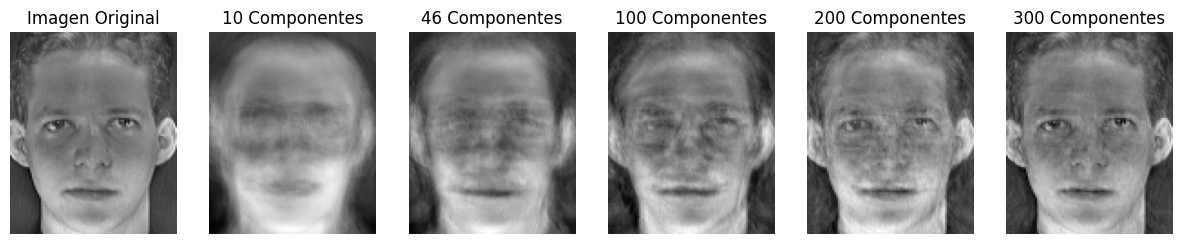

In [ ]:
# Suponiendo que tienes tu conjunto de datos original como 'X_std' ya estandarizado
# y 'image_shape' es la forma de cada imagen individual (altura, anchura)

# Seleccionar una imagen para la demostración
index_img = 0 # Índice de la imagen que se va a visualizar y reconstruir
original_image = X_std[index_img].reshape(image_shape)

# Lista de diferentes números de componentes para visualizar
componentes_a_probar = [10, 46, 100, 200, 300] # Puedes ajustar estos valores

# Configurar gráficos para la visualización
fig, axes = plt.subplots(1, len(componentes_a_probar) + 1, figsize=(15, 8))

# Visualizar la imagen original
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Imagen Original')
axes[0].axis('off')

# Reconstruir y visualizar la imagen con diferentes números de componentes principales
for i, n_componentes in enumerate(componentes_a_probar, start=1):
    # Aplicar PCA con n componentes
    pca = PCA(n_components=n_componentes)
    pca.fit(X_std)
    
    # Proyectar la imagen en el espacio reducido y reconstruir de vuelta al espacio original
    imagen_proyectada = pca.transform(X_std[index_img].reshape(1, -1))
    imagen_reconstruida = pca.inverse_transform(imagen_proyectada).reshape(image_shape)
    
    # Visualización de la imagen reconstruida
    axes[i].imshow(imagen_reconstruida, cmap='gray')
    axes[i].set_title(f'{n_componentes} Componentes')
    axes[i].axis('off')

plt.show()

### 6.2. Análisis de Componentes Principales (PCA) en el Reconocimiento Facial

#### Ventajas de PCA

- **Reducción de Dimensionalidad**: PCA reduce eficazmente la cantidad de datos conservando las características más significativas, lo que simplifica el modelo y reduce el tiempo de cómputo.
- **Eliminación de Ruido**: Al enfocarse en las componentes principales, PCA puede ayudar a filtrar el ruido de los datos, mejorando la calidad del reconocimiento facial.
- **Eficiencia en Almacenamiento y Computación**: La reducción de dimensiones disminuye los requisitos de almacenamiento y complejidad computacional, clave para procesamiento en tiempo real.
- **Facilidad de Implementación**: PCA es un método bien establecido, con amplia documentación y herramientas disponibles para su implementación.
- **Generalización**: La reducción a componentes principales puede ayudar a construir modelos que generalicen mejor a nuevos datos.

#### Limitaciones de PCA

- **Sensibilidad a Variaciones en Iluminación y Posición**: PCA puede ser sensible a cambios en iluminación y variaciones en la postura del rostro.
- **Pérdida de Información**: Al descartar componentes menos significativas, puede perderse información relevante para el reconocimiento facial.
- **Necesidad de Datos de Entrenamiento Representativos**: PCA requiere datos de entrenamiento representativos para identificar adecuadamente las componentes principales.
- **Linealidad**: Como método lineal, PCA puede no ser efectivo en capturar relaciones no lineales presentes en imágenes complejas.
- **Dificultades en la Interpretación de Componentes**: Las componentes principales no siempre tienen una interpretación física o visual clara.
- **Sensibilidad a Datos Atípicos**: PCA puede ser afectado significativamente por datos atípicos, sesgando los resultados.

En resumen, PCA es una herramienta poderosa para la reducción de dimensionalidad en el reconocimiento facial, pero tiene sus limitaciones en términos de sensibilidad a condiciones de iluminación, posición, pérdida de información y manejo de datos no lineales y atípicos.

## 7. Conclusiones

### 7.1. Hallazgos principales

El primer hallazgo significativo que encontramos, lo encontramos en [la visualización de las componentes principales](#3-visualización-de-los-componentes-principales) pues podemos ver como cada componente principal o en este caso eigenface se fija en una parte distinta de la imgaen. Esto es bastante significativo porque se puede decir que va cosntruyendo la imagen por capas y que cada capa es una componente principal.

El segundo hallazgo principal lo encontramos en la representacion de [las imágenes reconstruidas](#4-reducción-de-dimensionalidad-y-reconstrucción-de-imágenes) ya que podemos ver que las imágenes representadas con las Componentes Principales que representan el 80% de la varianza explicada no reconstruyen una imagen que sea clara a la vista humana y para llegar a tener una imagen clara a la vista humana deberíamos utilizar el triple de componentes al menos. Hya que recordar que quiza para un algoritmo le sirva con eso para podr identificar una imagen.

Por último, también podemos ver que el hecho de aplicar PCA en este caso concreto no hace que los tiempos de un [alogritmo como Knn](#5-clasificación-y-evaluación-del-rendimiento) tarde menos tiempo aunque tal y como se ha dicho con anterioridad eso pasa con este caso en particular y no significa que no pase siempre. Alomejor con datasets que sean mucho más grandes puede ser realmente interesante utilizarlo.